# VoIP Smart Number Classification

**Outcome**
- mplemented a Seq2Seq classifier model.
- Proposed a model that able to achieve over a 95% accuracy in classification of VoIP numbers. 
- The model was tested around 3000 VoIP numbers in four categories.

# Prepare DS

In [0]:
import subprocess


data_labeled = 'https://www.dropbox.com/.../ds_94220_labeled.csv'
data_unlabeled = 'https://www.dropbox.com/.../ds_94220_unlabeled.csv'
current_dir = '/tmp/voip-prj'

subprocess.run(["rm", "-rf", current_dir])
subprocess.run(["wget", data_labeled, "-P", current_dir])
subprocess.run(["wget", data_unlabeled, "-P", current_dir])

!ls /tmp/voip-prj/

ds_94220_labeled.csv  ds_94220_unlabeled.csv


# Import Packages

In [0]:
!pip install -U -q xlrd
!pip install -U -q scikit-learn
!pip install -U -q openpyxl
!pip install -U -q keras

In [0]:
# OpenCV
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

# GraphViz
!apt-get -qq install -y graphviz && pip install -q pydot

# 7zip
!apt-get -qq install -y libarchive-dev && pip install -q -U libarchive

In [0]:
import pandas as pd
import numpy as np
import time
import os
import sys

import matplotlib
from matplotlib import pyplot as plt

import keras
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, TimeDistributed
from keras.layers import SimpleRNN, LSTM
from keras import initializers
from keras.optimizers import RMSprop

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

%matplotlib inline

Using TensorFlow backend.


# Load the data

In [0]:
# Training parameters.
batch_size = 32
num_classes = 4
epochs = 80

# Embedding dimensions.
row_hidden = 256
col_hidden = 256


data = pd.read_csv(os.path.join(current_dir, 'ds_94220_labeled.csv'))
classes = list(set(data['Group'].as_matrix()))
classes.sort()

data['Group'] = data['Group'].apply(lambda x: classes.index(int(x)))
data.head()

,Telephone,Group
0,9422072686,0
1,9422047512,0
2,9422039760,0
3,9422075296,0
4,9422093687,0


In [0]:
udata = pd.read_csv(os.path.join(current_dir, 'ds_94220_unlabeled.csv'), header=None)
udata.columns = ['Telephone']
udata['length'] = udata['Telephone'].apply(lambda x: len([digit for digit in str(x)]))
udata.head()

,Telephone,length
0,9422000000,10
1,9422000001,10
2,9422000002,10
3,9422000003,10
4,9422000004,10


In [0]:
numbers = data['Telephone'].as_matrix()
groups = data['Group'].as_matrix()

print(len(numbers))
print(len(groups))

5168
5168


# Preprocessing

In [0]:
ni, mi = numbers.shape[0], list(set([len([int(n) for n in str(number)]) for number in numbers]))[0]

print('X: {}*{}'.format(ni, mi))

X: 5168*10


In [0]:
X = np.zeros((ni, mi))
             
for i in range(len(numbers)):
    X[i] = np.array([int(n) for n in str(numbers[i])])

X = X.reshape((-1, 1, mi)).astype(np.int32)
Y = groups.astype(np.int32)

In [0]:
Xs, Ys = shuffle(X, Y, random_state=42)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(Xs, Ys, test_size=0.1, random_state=42)

In [0]:
# Reshapes data to 4D for Hierarchical RNN.
x_train = x_train.reshape(x_train.shape[0], 1, mi, 1)
x_test = x_test.reshape(x_test.shape[0], 1, mi, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (4651, 1, 10, 1)
4651 train samples
517 test samples


In [0]:
# Converts class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
row, col, pixel = x_train.shape[1:]

print('row {}, col {}, pixel {}'.format(row, col, pixel))

row 1, col 10, pixel 1


# Implement the model

In [0]:
# 4D input.
x = Input(shape=(row, col, pixel))

# Encodes a row of pixels using TimeDistributed Wrapper.
encoded_rows = TimeDistributed(LSTM(row_hidden))(x)

# Encodes columns of encoded rows.
encoded_columns = LSTM(col_hidden)(encoded_rows)

prediction = Dense(num_classes, activation='softmax')(encoded_columns)

model = Model(x, prediction)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 10, 1)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 256)            264192    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 790,532
Trainable params: 790,532
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 4651 samples, validate on 517 samples
Epoch 1/80
4651/4651 [==============================] - 6s 1ms/step - loss: 1.2324 - acc: 0.4476 - val_loss: 1.1575 - val_acc: 0.4700
Epoch 2/80
4651/4651 [==============================] - 5s 996us/step - loss: 1.0683 - acc: 0.5126 - val_loss: 1.0045 - val_acc: 0.5493
Epoch 3/80
4651/4651 [==============================] - 5s 1ms/step - loss: 0.9367 - acc: 0.5786 - val_loss: 0.8839 - val_acc: 0.5938
Epoch 4/80
4651/4651 [==============================] - 5s 1000us/step - loss: 0.8103 - acc: 0.6691 - val_loss: 0.7305 - val_acc: 0.7118
Epoch 5/80
4651/4651 [==============================] - 5s 980us/step - loss: 0.6681 - acc: 0.7459 - val_loss: 0.6140 - val_acc: 0.7544
Epoch 6/80
4651/4651 [==============================] - 5s 994us/step - loss: 0.5814 - acc: 0.7794 - val_loss: 0.6434 - val_acc: 0.7524
Epoch 7/80
4651/4651 [==============================] - 5s 994us/step - loss: 0.5182 - acc: 

# Plot

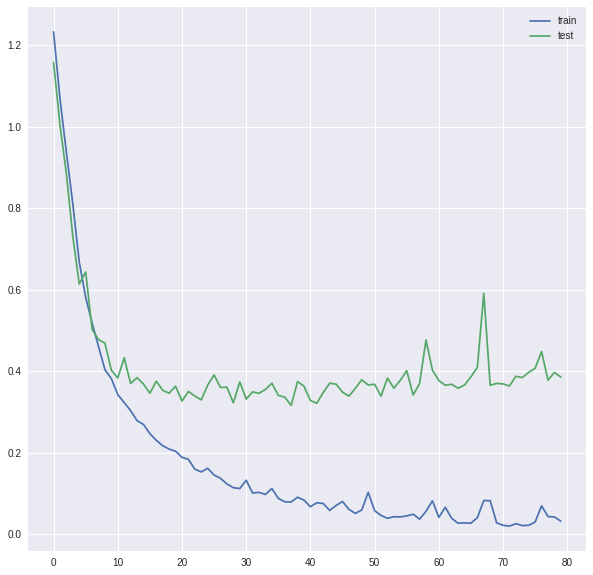

In [0]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

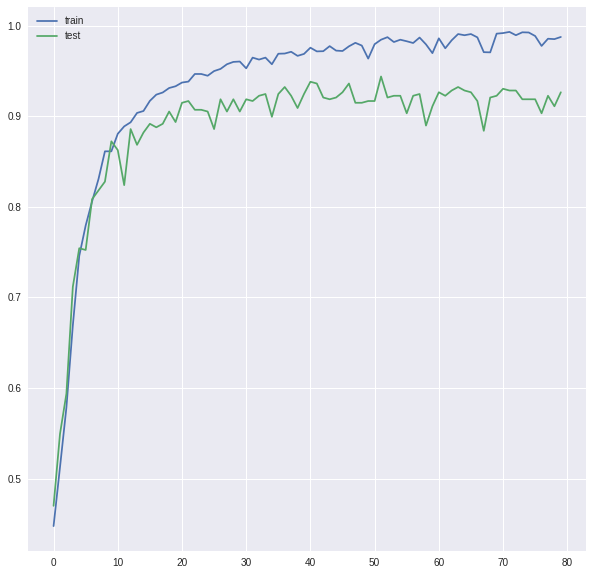

In [0]:
plt.figure(figsize=(10,10))
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

# Evaluation

In [0]:
# Evaluation.
scores = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.38565606951922526
Test accuracy: 0.9264990328820116


# Prediction

In [0]:
predicts = model.predict(x_test, verbose=0)
predicts = np.argmax(predicts, axis=1)
trues = np.argmax(y_test, axis=1)


print(predicts.shape)
print(trues.shape)

(517,)
(517,)


In [0]:
u_numbers = udata['Telephone'].as_matrix()
uX = np.zeros((u_numbers.shape[0], mi))
             
for i in range(u_numbers.shape[0]):
    uX[i] = np.array([int(n) for n in str(u_numbers[i])])

uX = uX.reshape(uX.shape[0], 1, mi, 1)
uP = np.argmax(model.predict(uX, verbose=0), axis=1)

print(uX.shape)
print(uP.shape)

(100000, 1, 10, 1)
(100000,)


In [0]:
target_names = ['Customary', 'Bronzy', 'Silvery', 'Golden']
udata['Label'] = uP
udata['Label'] = udata['Label'].apply(lambda x: target_names[x])
udata.head()

,Telephone,length,Label
0,9422000000,10,Golden
1,9422000001,10,Golden
2,9422000002,10,Golden
3,9422000003,10,Golden
4,9422000004,10,Golden


# Predict and Evaluate

In [0]:
orgi_x = X.reshape(X.shape[0], 1, mi, 1)
orgi_y = Y
pred_y = np.argmax(model.predict(orgi_x, verbose=0), axis=1)

df = {
    'Originals': orgi_y,
    'predictions': pred_y,
}

df_dt = pd.DataFrame(df)
df_dt.head()

,Originals,predictions
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [0]:
from sklearn.metrics import classification_report


target_names = ['Customary', 'Bronzy', 'Silvery', 'Golden']
print(classification_report(orgi_y, pred_y, target_names=target_names))

              precision    recall  f1-score   support

   Customary       0.99      0.97      0.98       879
      Bronzy       0.99      1.00      0.99      2126
     Silvery       0.98      0.98      0.98      1282
      Golden       0.99      0.97      0.98       881

   micro avg       0.99      0.99      0.99      5168
   macro avg       0.99      0.98      0.98      5168
weighted avg       0.99      0.99      0.99      5168



# Save the model

In [0]:
import json
from keras.models import model_from_json, load_model

# Option 1: Save Weights + Architecture
model.save_weights(os.path.join(current_dir, 'ds_94220_model_weights.h5'))

with open(os.path.join(current_dir, 'ds_94220_model_architecture.json'), 'w') as f:
    f.write(model.to_json())
    
model.save(os.path.join(current_dir, 'ds_94220_model_seq1seq.h5'))

udata.to_csv(os.path.join(current_dir, 'ds_94220_labeled-trained.csv'))